Fitting 3 folds for each of 81 candidates, totalling 243 fits

✅ Best Params: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 0.0001, 'lambda_2': 1e-06}
⏱ Training Time: 123.03 seconds

📊 Test Results (Bayesian Ridge Tuned):
MAE:  121.31
RMSE: 249.55
R²:   0.4575


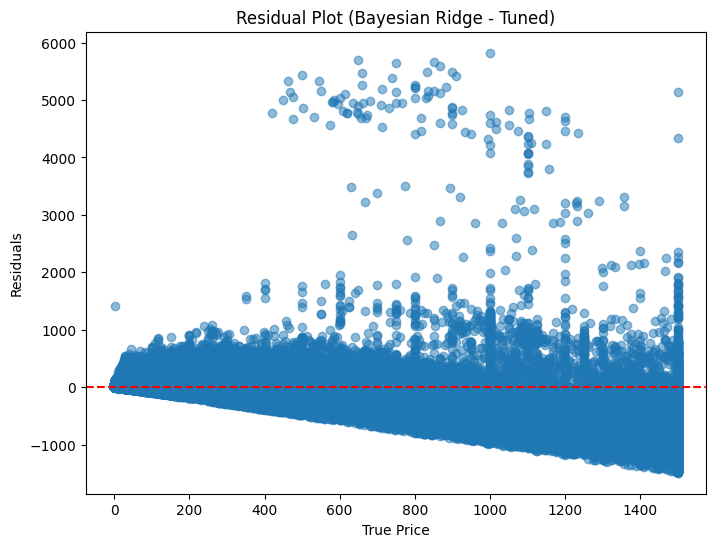

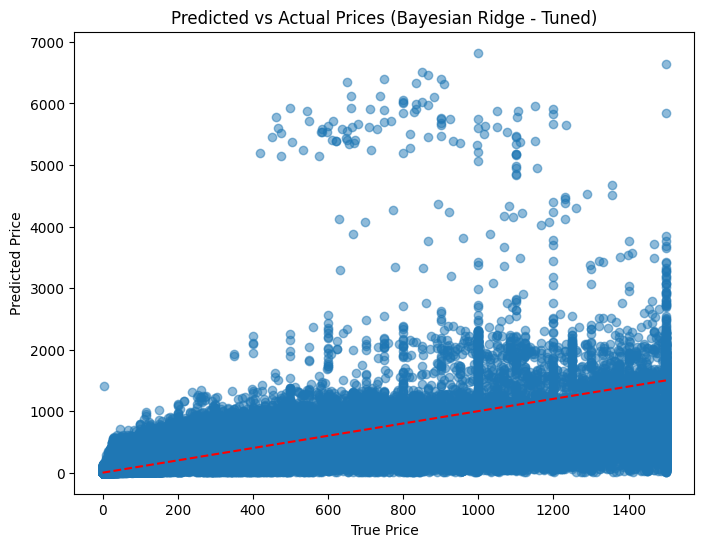

In [6]:
# --- Install ---
!pip install -q category_encoders

# --- Imports ---
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# --- Utility Functions ---
def preprocess_target(y, clip_percentile=99.0):
    y_clipped = np.clip(y, 1e-6, np.percentile(y, clip_percentile))
    return np.log1p(y_clipped)

def inverse_preprocess_target(y): return np.expm1(y)

def cyclical_encode_month(df, col='mp_month'):
    df[f'{col}_sin'] = np.sin(2 * np.pi * (df[col] - 1) / 12)
    df[f'{col}_cos'] = np.cos(2 * np.pi * (df[col] - 1) / 12)
    return df

def remove_outliers(df, column='mp_price', iqr_multiplier=1.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)].reset_index(drop=True)

# --- Load and Preprocess Data ---
df = pd.read_csv("wfp_food_prices_database.csv", low_memory=False)
df = df.drop(columns=["mp_commoditysource", "adm0_name", "adm1_name", "mkt_name", "cur_name", "pt_name", "um_name"], errors='ignore')
df = df[df["mp_price"] > 0].reset_index(drop=True)
df = remove_outliers(df)
df = cyclical_encode_month(df)
df["adm1_mean_price"] = df.groupby("adm1_id")["mp_price"].transform("mean")

# Convert categorical columns to strings
for col in ["adm1_id", "cm_id", "cur_id", "pt_id", "um_id"]:
    df[col] = df[col].astype(str)

# --- Define Features and Target ---
X = df[[ "adm1_id", "cm_id", "cm_name", "cur_id", "pt_id", "um_id",
         "mp_month_sin", "mp_month_cos", "mp_year", "adm1_mean_price" ]]
y = preprocess_target(df["mp_price"])

# --- Preprocessing ---
cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes(["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", TargetEncoder(min_samples_leaf=5, smoothing=10.0), cat_cols)
])
X_processed = preprocessor.fit_transform(X, y)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# --- Grid Search for Bayesian Ridge ---
param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

grid_search = GridSearchCV(
    estimator=BayesianRidge(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# --- Best Model ---
best_model = grid_search.best_estimator_
print(f"\n✅ Best Params: {grid_search.best_params_}")
print(f"⏱ Training Time: {training_time:.2f} seconds")

# --- Evaluation ---
y_pred = best_model.predict(X_test)
y_pred_orig = inverse_preprocess_target(y_pred)
y_test_orig = inverse_preprocess_target(y_test)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print(f"\n📊 Test Results (Bayesian Ridge Tuned):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# --- Residual Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig - y_test_orig, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Residuals")
plt.title("Residual Plot (Bayesian Ridge - Tuned)")
plt.show()

# --- Predicted vs Actual ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (Bayesian Ridge - Tuned)")
plt.show()
